In [1]:
import pandas as pd
import seaborn
from scipy.stats import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import *
from sklearn.tree import DecisionTreeRegressor


In [2]:
# Read in the training data set
df = pd.read_csv('data/train.csv', sep=',',keep_default_na=False, na_values='null')
# Display shape of the data
print(df.shape)
print(df)

(13288920, 13)
                id           valid_time  latitude  longitude            tp  \
0                1  2018-01-01 00:00:00      59.0      -8.00  3.814697e-06   
1                2  2018-01-01 00:00:00      59.0      -7.75  1.668930e-05   
2                3  2018-01-01 00:00:00      59.0      -7.50  1.811981e-05   
3                4  2018-01-01 00:00:00      59.0      -7.25  1.907349e-05   
4                5  2018-01-01 00:00:00      59.0      -7.00  1.525879e-05   
...            ...                  ...       ...        ...           ...   
13288915  13288916  2018-12-31 23:00:00      50.0       1.00  1.239777e-05   
13288916  13288917  2018-12-31 23:00:00      50.0       1.25  1.621246e-05   
13288917  13288918  2018-12-31 23:00:00      50.0       1.50  3.814697e-06   
13288918  13288919  2018-12-31 23:00:00      50.0       1.75  1.907349e-06   
13288919  13288920  2018-12-31 23:00:00      50.0       2.00  9.536743e-07   

               u10       v10          sp      u1

In [3]:
X_train = df.drop(columns=['t2m'])  # Features
y_train = df['t2m']  # Labels (y can be true or false)

In [4]:
# Finding attribute characteristics:
def analyze_dataframe(explore_df):
    results = []
    for col in explore_df.columns:
        col_data = explore_df[col]
        dtype = col_data.dtype
        # Get percentage of missing data
        missing = (len(explore_df[explore_df[col] == "unknown"]) / len(explore_df)) * 100
        # Determine the noisiness of results (if there are outliers) (only for numerical)
        if np.issubdtype(dtype, np.number):
            # Find z-score (how far a data point is from the mean)
            z_scores = np.abs(stats.zscore(col_data)) if len(col_data) > 1 else np.array([])
            outliers = np.sum(z_scores > 3)  # Count outliers, we define as z score of more than 3
            noise_type = []
            if outliers > 0:
                # If there are outliers,
                noise_desc = "Outliers"
            else:
                noise_desc = "None"
        else:
            noise_desc = "None"
        # Determining the type of distribution (only for numerical)
        if np.issubdtype(dtype, np.number) and len(col_data) > 1:
            skewness = stats.skew(col_data)
            if np.all(col_data >= 0) and skewness > 1:
                distribution = "Log-normal"
            elif -0.5 < skewness < 0.5:
                distribution = "Gaussian"
            else:
                distribution = "Other"
        else:
            distribution = "Categorical" if explore_df[col].dtype == 'object' else "Uniform"

        results.append([col, str(dtype), f"{missing:.2f}%", noise_desc, distribution])
    return pd.DataFrame(results, columns=["Name", "Type", "% Missing", "Noisiness", "Distribution"])


explore_df = df.copy(deep=True)

analyze_dataframe(explore_df)

/var/folders/7x/9t6kbk7527155j9m2f98pg040000gn/T/ipykernel_87054/1745696632.py:12: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  z_scores = np.abs(stats.zscore(col_data)) if len(col_data) > 1 else np.array([])
/var/folders/7x/9t6kbk7527155j9m2f98pg040000gn/T/ipykernel_87054/1745696632.py:24: DeprecationWarning: Please import `skew` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  skewness = stats.skew(col_data)
/var/folders/7x/9t6kbk7527155j9m2f98pg040000gn/T/ipykernel_87054/1745696632.py:12: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  z_scores = np.abs(stats.zscore(col_data)) if len(col_data) > 1 else np.array([])
/var/folders/7x/9t6kbk7527155j9m2f98pg040000gn/T/ipykernel_87054/17456

,Name,Type,% Missing,Noisiness,Distribution
0,id,int64,0.00%,None,Gaussian
1,valid_time,object,0.00%,None,Categorical
2,latitude,float64,0.00%,None,Gaussian
3,longitude,float64,0.00%,None,Gaussian
4,tp,float64,0.00%,Outliers,Log-normal
5,u10,float64,0.00%,Outliers,Gaussian
6,v10,float64,0.00%,Outliers,Gaussian
7,sp,float64,0.00%,Outliers,Other
8,u100,float64,0.00%,Outliers,Gaussian
9,v100,float64,0.00%,Outliers,Gaussian


In [5]:
# pd.plotting.scatter_matrix(explore_df, figsize=(15,15))
# plt.show()
# plt.close()

In [6]:
explore_df.corr(numeric_only=True)

,id,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m
id,1.000000,-1.141136e-04,3.084359e-06,0.020646,0.072310,0.110830,0.103652,0.074792,0.114604,0.014057,-0.167003,0.356714
latitude,-0.000114,1.000000e+00,2.178158e-18,0.024489,-0.005567,0.133112,-0.118997,-0.003451,0.132627,0.056854,0.074319,-0.192024
longitude,0.000003,2.178158e-18,1.000000e+00,-0.070298,-0.033214,-0.033994,0.156200,-0.028453,-0.040022,-0.076165,-0.046142,0.019020
tp,0.020646,2.448939e-02,-7.029830e-02,1.000000,-0.027792,0.154852,-0.216148,-0.025559,0.166691,0.237507,0.139939,-0.031759
u10,0.072310,-5.567233e-03,-3.321351e-02,-0.027792,1.000000,0.011208,-0.042757,0.988070,-0.015877,-0.049808,-0.156899,0.173913
v10,0.110830,1.331121e-01,-3.399388e-02,0.154852,0.011208,1.000000,-0.151017,0.053362,0.989435,0.199292,-0.023864,0.071270
sp,0.103652,-1.189974e-01,1.562004e-01,-0.216148,-0.042757,-0.151017,1.000000,-0.058544,-0.176129,-0.189439,-0.217448,0.246608
u100,0.074792,-3.451025e-03,-2.845290e-02,-0.025559,0.988070,0.053362,-0.058544,1.000000,0.027012,-0.035896,-0.154219,0.169121
v100,0.114604,1.326269e-01,-4.002153e-02,0.166691,-0.015877,0.989435,-0.176129,0.027012,1.000000,0.209839,-0.021807,0.072740
tcc,0.014057,5.685422e-02,-7.616496e-02,0.237507,-0.049808,0.199292,-0.189439,-0.035896,0.209839,1.000000,0.198153,-0.064540


(array([5.193000e+03, 9.510400e+04, 5.028950e+05, 2.203763e+06,
        4.708570e+06, 3.704711e+06, 1.554529e+06, 4.374130e+05,
        7.355800e+04, 3.184000e+03]),
 array([-19.073944, -14.850653, -10.627362,  -6.404071,  -2.18078 ,
          2.042511,   6.265802,  10.489093,  14.712384,  18.935675,
         23.158966]),
 <BarContainer object of 10 artists>)

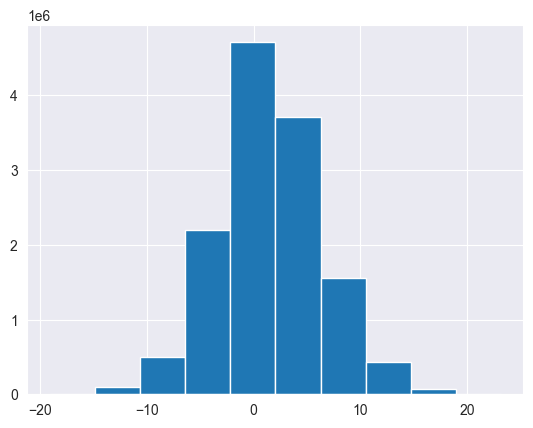

In [7]:
plt.hist(explore_df['v10'])

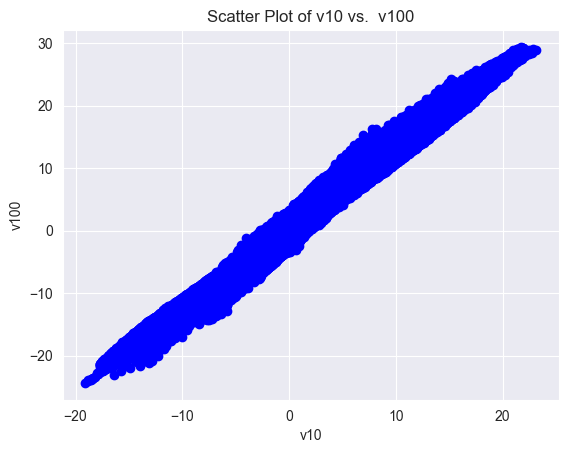

In [8]:
# Scatter plot
plt.scatter(explore_df['v10'], explore_df['v100'], color='blue', marker='o')
plt.xlabel('v10')
plt.ylabel('v100')
plt.title('Scatter Plot of v10 vs.  v100')
plt.show()

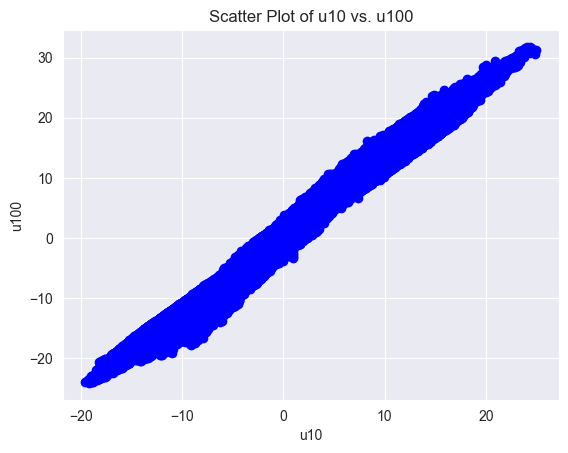

In [9]:
# Scatter plot
plt.scatter(explore_df['u10'], explore_df['u100'], color='blue', marker='o')
plt.xlabel('u10')
plt.ylabel('u100')
plt.title('Scatter Plot of u10 vs. u100')
plt.show()

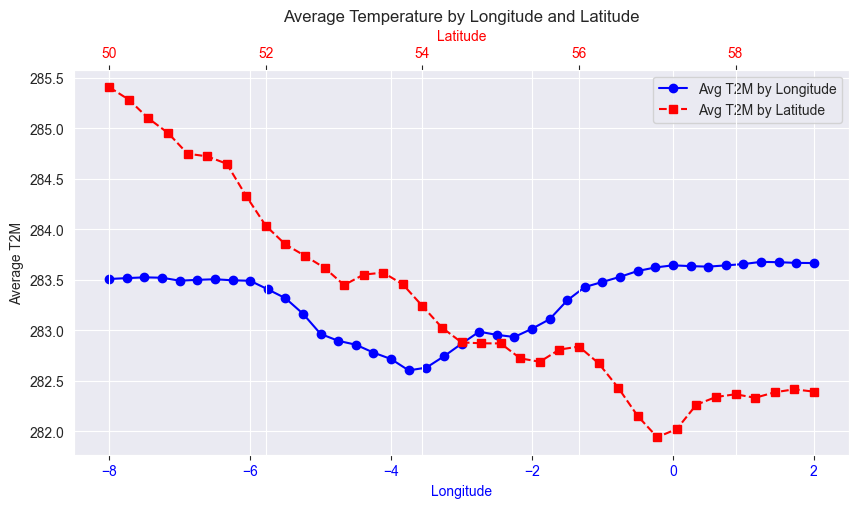

In [10]:
# Group by longitude/latitude
avg_temps_by_longitude = explore_df.groupby('longitude')['t2m'].mean().reset_index()
avg_temps_by_latitude = explore_df.groupby('latitude')['t2m'].mean().reset_index()
avg_temps_by_longitude = avg_temps_by_longitude.sort_values(by='longitude')
avg_temps_by_latitude = avg_temps_by_latitude.sort_values(by='latitude')

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(avg_temps_by_longitude['longitude'], avg_temps_by_longitude['t2m'], marker='o', linestyle='-', color='blue', label='Avg T2M by Longitude')
ax1.set_xlabel('Longitude', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

# Secondary Axis
ax2 = ax1.twiny()
ax2.plot(avg_temps_by_latitude['latitude'], avg_temps_by_latitude['t2m'], marker='s', linestyle='--', color='red', label='Avg T2M by Latitude')
ax2.set_xlabel('Latitude', color='red')
ax2.tick_params(axis='x', labelcolor='red')

# Labels/Legends
ax1.set_ylabel('Average T2M')
ax1.set_title('Average Temperature by Longitude and Latitude')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

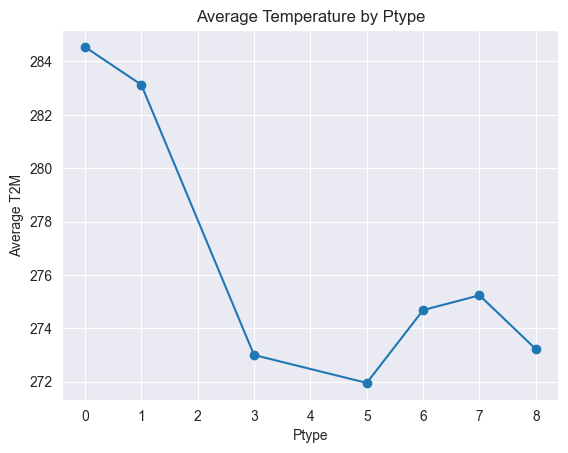

In [11]:
avg_temps_by_ptype = explore_df.groupby('ptype')['t2m'].mean().reset_index()
avg_temps_by_ptype = avg_temps_by_ptype.sort_values(by='ptype')
plt.plot(avg_temps_by_ptype['ptype'], avg_temps_by_ptype['t2m'], marker='o', linestyle='-')

# Labels and title
plt.xlabel('Ptype')
plt.ylabel('Average T2M')
plt.title('Average Temperature by Ptype')

# Show the plot
plt.show()

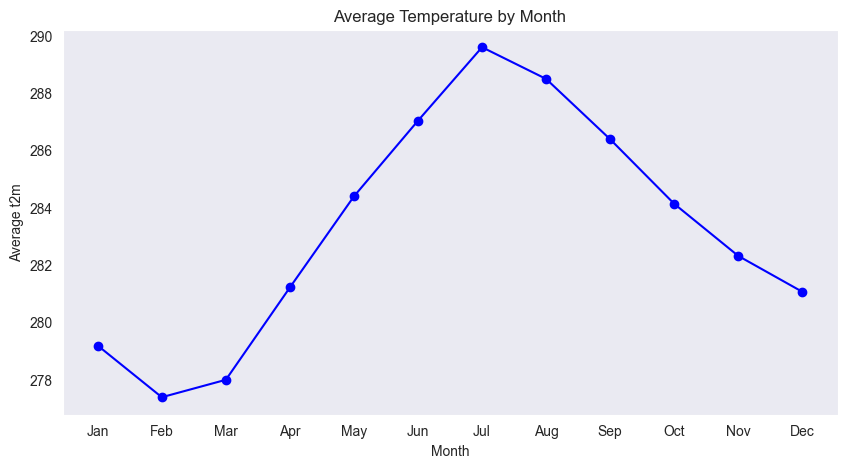

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'valid_time' to datetime format
explore_df['valid_time'] = pd.to_datetime(explore_df['valid_time'])

# Extract month and calculate the average t2m
explore_df['month'] = explore_df['valid_time'].dt.month
monthly_avg_temp = explore_df.groupby('month')['t2m'].mean()

# Plot the monthly average t2m
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_temp.index, monthly_avg_temp.values, marker='o', linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


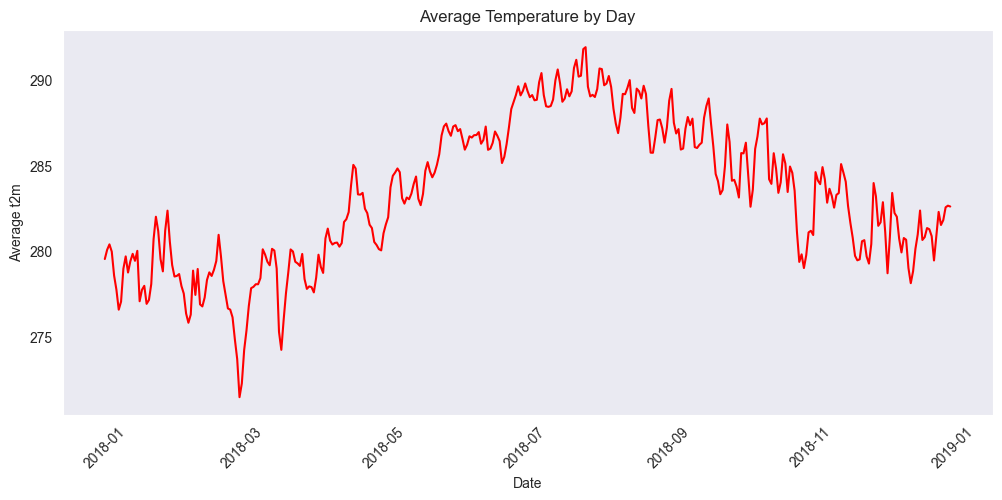

In [13]:
explore_df['date'] = explore_df['valid_time'].dt.date
daily_avg_temp = explore_df.groupby('date')['t2m'].mean()
plt.figure(figsize=(12, 5))
plt.plot(daily_avg_temp.index, daily_avg_temp.values, color='r')
plt.xlabel('Date')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Day')
plt.xticks(rotation=45)
plt.grid()
plt.show()

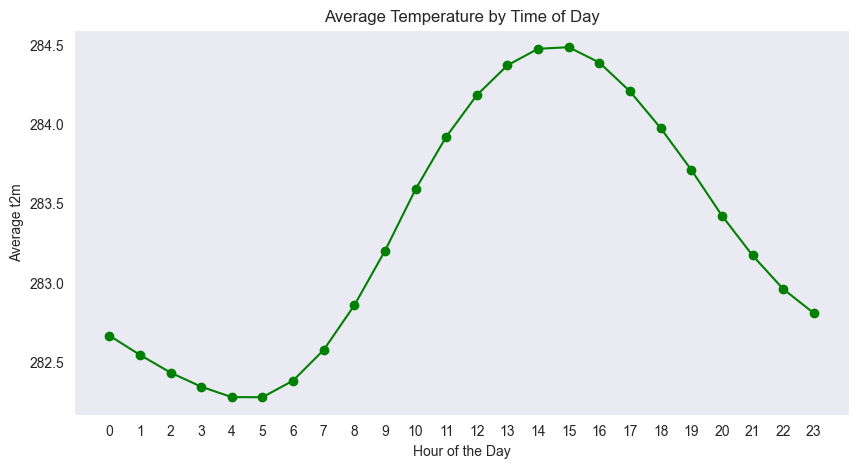

In [14]:
explore_df['valid_time'] = pd.to_datetime(explore_df['valid_time'])
explore_df['hour'] = explore_df['valid_time'].dt.hour
hourly_avg_temp = explore_df.groupby('hour')['t2m'].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg_temp.index, hourly_avg_temp.values, marker='o', linestyle='-', color='g')
plt.xlabel('Hour of the Day')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Time of Day')
plt.xticks(range(0, 24))  # Show every hour on x-axis
plt.grid()
plt.show()

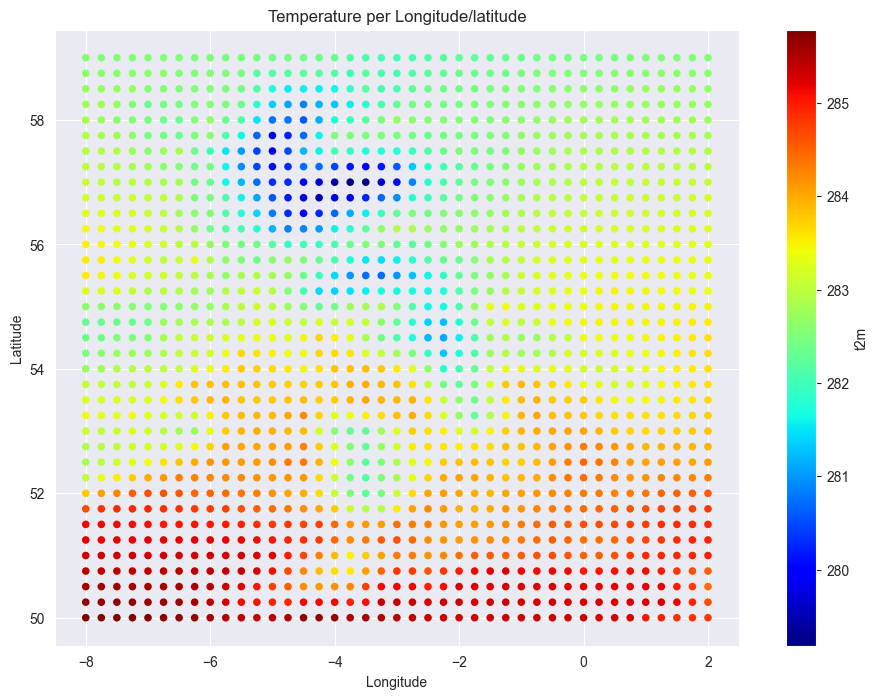

In [15]:
df_max = explore_df.groupby(['longitude', 'latitude'], as_index=False)['t2m'].mean()

# Scatter plot using longitude and latitude as coordinates
map = df_max.plot.scatter(
    x='longitude',
    y='latitude',
    c='t2m',
    cmap='jet',
    colorbar=True,
    figsize=(12, 8),
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Temperature per Longitude/latitude")
map.set_aspect('equal')
plt.show()

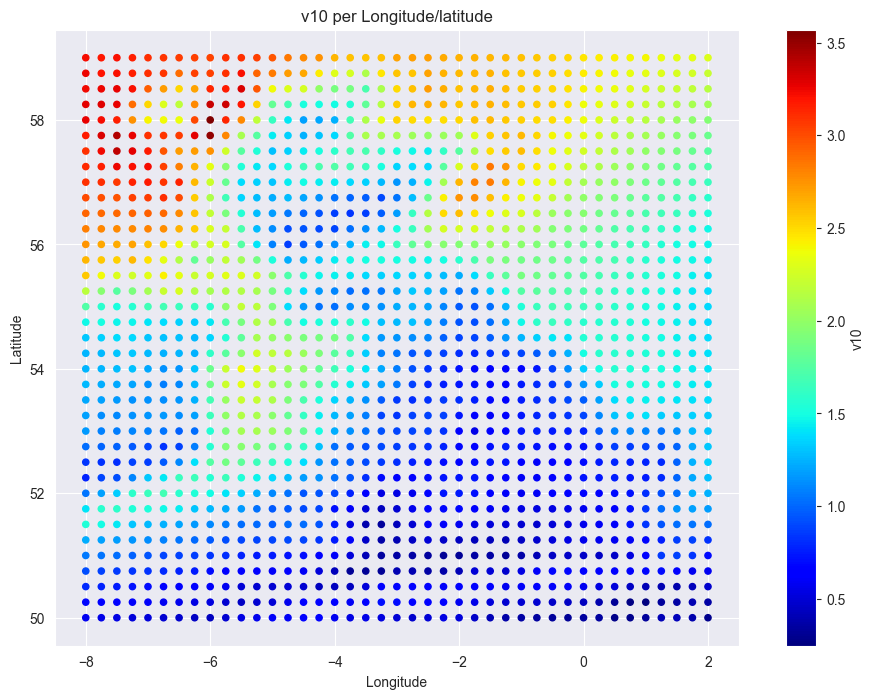

In [16]:
df_max = explore_df.groupby(['longitude', 'latitude'], as_index=False)['v10'].mean()

# Scatter plot using longitude and latitude as coordinates
map = df_max.plot.scatter(
    x='longitude',
    y='latitude',
    c='v10',
    cmap='jet',
    colorbar=True,
    figsize=(12, 8),
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("v10 per Longitude/latitude")
map.set_aspect('equal')
plt.show()

# Data Wrangling

In [17]:
def split_times(df):
    df['valid_time'] = pd.to_datetime(df['valid_time'])
    df['hour'] = df['valid_time'].dt.hour
    df['month'] = df['valid_time'].dt.month
    df['day'] = df['valid_time'].dt.dayofweek
    return df

In [18]:
def feature_selection(df):
        return df.drop(columns=['id', 'valid_time'])

In [19]:
X_train = split_times(X_train)
X_train = feature_selection(X_train)
print(X_train)

          latitude  longitude            tp       u10       v10          sp  \
0             59.0      -8.00  3.814697e-06  1.405868 -1.367767   98134.810   
1             59.0      -7.75  1.668930e-05  2.151962 -1.555267   98086.810   
2             59.0      -7.50  1.811981e-05  2.691025 -1.585541   98078.810   
3             59.0      -7.25  1.907349e-05  2.850204 -1.714447   98076.810   
4             59.0      -7.00  1.525879e-05  3.299423 -1.867767   98084.810   
...            ...        ...           ...       ...       ...         ...   
13288915      50.0       1.00  1.239777e-05  2.973770 -0.559326  102930.375   
13288916      50.0       1.25  1.621246e-05  2.772598 -0.156982  102743.375   
13288917      50.0       1.50  3.814697e-06  2.175919  0.240479  102498.375   
13288918      50.0       1.75  1.907349e-06  2.238419  0.259033  102425.375   
13288919      50.0       2.00  9.536743e-07  2.154434  0.307861  102450.375   

              u100      v100       tcc  ptype  hour

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.7, random_state=42, shuffle=True
)

# Model Training

In [22]:
# Read in the test data set
# df = pd.read_csv('data/train.csv', sep=',',keep_default_na=False, na_values='null')
# X_test = df.drop(columns=['t2m'])  # Features
# y_test = df['t2m']  # Labels (y can be true or false)

In [23]:
categorical = ["hour", "day", "month"]
numerical = ["tp", "u10", "v10", "u100", "v100", "tcc", "ptype", "longitude", "latitude"]

In [24]:
def preprocess_data(X_train, y_train, standard_scaler, test):
    # Initialising encoders
    one_hot_encoder = OneHotEncoder(sparse_output=True)
    if standard_scaler:
        # If applying standard scaler
        scaler = StandardScaler()
        # Apply all scalers/encoders at once
        preprocessor = ColumnTransformer(transformers=[
        ('num', scaler, numerical),
        ('cat', one_hot_encoder, categorical)],
            verbose=True, remainder='passthrough')
    else:
        # Apply all encoders at once
        preprocessor = ColumnTransformer(transformers=[
        ('cat', one_hot_encoder, categorical)],
            verbose=True, remainder='passthrough')
    preprocessor.fit(X_train, y=y_train)
    training = preprocessor.transform(X_train)
    if test:
        validation = preprocessor.transform(X_valid)
    else:
        validation = preprocessor.transform(X_valid)
    return training, validation

In [39]:
X_train_sample = X_train.sample(n=30000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
# X_valid_sample = X_valid.sample(n=3000, random_state=42)
# y_valid_sample = y_valid.loc[X_valid_sample.index]

In [26]:
sgd_training, sgd_validation = preprocess_data(X_train_sample, y_train_sample, False, False) # Get data
sgd_reg = SGDRegressor()
sgd_reg.fit(sgd_training, y_train_sample)

[ColumnTransformer] ........... (1 of 2) Processing cat, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


SGDRegressor()

In [27]:
sgd_predictions = sgd_reg.predict(sgd_training)

mse = mean_squared_error(y_train_sample, sgd_predictions)
mae = mean_absolute_error(y_train_sample, sgd_predictions)
r2 = r2_score(y_train_sample, sgd_predictions)

print("SGD Regressor on training data:")
print("MSE:", round(mse, 3),
      "MAE:", round(mae, 3),
      "R2 Score:", round(r2, 3))

SGD Regressor on training data:
MSE: 1.5597234106591025e+36 MAE: 1.2487173552028838e+18 R2 Score: -6.405806209239876e+34


In [28]:
sgd_predictions_vl = sgd_reg.predict(sgd_validation)
mse = mean_squared_error(y_valid, sgd_predictions_vl)
mae = mean_absolute_error(y_valid, sgd_predictions_vl)
r2 = r2_score(y_valid, sgd_predictions_vl)

print("SGD Regressor on validation data:")
print("MSE:", round(mse, 3),
      "MAE:", round(mae, 3),
      "R2 Score:", round(r2, 3))

SGD Regressor on validation data:
MSE: 1.5596089428529637e+36 MAE: 1.2486757899100175e+18 R2 Score: -6.499657475433187e+34


In [ ]:
rf_training, rf_validation = preprocess_data(X_train_sample, y_train_sample, False, False) # Get data
rf_reg = RandomForestRegressor()
rf_reg.fit(rf_training, y_train_sample)

[ColumnTransformer] ........... (1 of 2) Processing cat, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


In [37]:
rf_preds = rf_reg.predict(rf_training)

# Calculate metrics
rf_mse = mean_squared_error(y_train_sample, rf_preds)
rf_mae = mean_absolute_error(y_train_sample, rf_preds)
rf_r2 = r2_score(y_train_sample, rf_preds)

# Print results
print("Random Forest Regressor on training data:")
print(f"MSE: {rf_mse:.3f}")
print(f"MAE: {rf_mae:.3f}")
print(f"R2 Score: {rf_r2:.3f}")

Random Forest Regressor on training data:
MSE: 0.470
MAE: 0.472
R2 Score: 0.981


In [38]:
rf_preds_vl = rf_reg.predict(rf_validation)

# Calculate metrics
rf_mse_vl = mean_squared_error(y_valid, rf_preds_vl)
rf_mae_vl = mean_absolute_error(y_valid, rf_preds_vl)
rf_r2_vl = r2_score(y_valid, rf_preds_vl)

# Print results
print("Random Forest Regressor on validation data:")
print(f"MSE: {rf_mse_vl:.3f}")
print(f"MAE: {rf_mae_vl:.3f}")
print(f"R2 Score: {rf_r2_vl:.3f}"

Random Forest Regressor on validation data:
MSE: 3.370
MAE: 1.264
R2 Score: 0.860


In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_training, tree_validation = preprocess_data(X_train_sample, y_train_sample, False, False) # Get data
tree_reg = DecisionTreeRegressor()
tree_reg.fit(tree_training, y_train_sample)

[ColumnTransformer] ........... (1 of 2) Processing cat, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


DecisionTreeRegressor()

In [33]:
tree_preds = tree_reg.predict(tree_training)

# Calculate metrics
tree_mse = mean_squared_error(y_train_sample, tree_preds)
tree_mae = mean_absolute_error(y_train_sample, tree_preds)
tree_r2 = r2_score(y_train_sample, tree_preds)

# Print results
print("Random Forest Regressor on training data:")
print(f"MSE: {tree_mse:.3f}")
print(f"MAE: {tree_mae:.3f}")
print(f"R2 Score: {tree_r2:.3f}")

Random Forest Regressor on training data:
MSE: 0.000
MAE: 0.000
R2 Score: 1.000


In [34]:
tree_preds_vl = tree_reg.predict(tree_validation)

# Calculate metrics
tree_mse_vl = mean_squared_error(y_valid, tree_preds_vl)
tree_mae_vl = mean_absolute_error(y_valid, tree_preds_vl)
tree_r2_vl = r2_score(y_valid, tree_preds_vl)

# Print results
print("Decision Tree on validation data:")
print(f"MSE: {tree_mse_vl:.3f}")
print(f"MAE: {tree_mae_vl:.3f}")
print(f"R2 Score: {tree_r2_vl:.3f}")

Decision Tree on validation data:
MSE: 7.947
MAE: 1.953
R2 Score: 0.669
